In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
DATA_DIR = '/kaggle/input/dataset-mat-cat' 
BATCH_SIZE = 32
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"⚙️ Đang sử dụng thiết bị: {DEVICE}")

⚙️ Đang sử dụng thiết bị: cuda


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),      # Lật ngang
        transforms.RandomRotation(20),               # Xoay nghiêng  20 độ
        transforms.ColorJitter(brightness=0.2,       # Đổi độ sáng
                               contrast=0.2,         # Đổi tương phản
                               saturation=0.2,       # Đổi độ bão hòa
                               hue=0.1),             # Đổi tông màu nhẹ
        transforms.RandomGrayscale(p=0.1),           # Thỉnh thoảng chuyển sang ảnh đen trắng
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1)) # Xóa ngẫu nhiên 1 vùng nhỏ 
    ]),
    'valid': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
train_dir = os.path.join(DATA_DIR, 'train')
valid_dir = os.path.join(DATA_DIR, 'valid')
if not os.path.exists(valid_dir):
    train_dir = os.path.join(DATA_DIR, 'Dataset_Mat_Cat', 'train')
    valid_dir = os.path.join(DATA_DIR, 'Dataset_Mat_Cat', 'valid')

image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, data_transforms['valid'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'valid': DataLoader(image_datasets['valid'], batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

print(f"✅ Đã load dữ liệu: Train ({dataset_sizes['train']}), Valid ({dataset_sizes['valid']})")
print(f"📋 Các lớp: {class_names}")

✅ Đã load dữ liệu: Train (11703), Valid (1902)
📋 Các lớp: ['anger', 'content', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'efficientnet_b0_best_checkpoint.pth')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

print("🏗️ Đang khởi tạo EfficientNet-B0...")
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(num_ftrs, len(class_names))
)

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()

🏗️ Đang khởi tạo EfficientNet-B0...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 136MB/s]



❄️ GIAI ĐOẠN 1: ĐÓNG BĂNG (WARM-UP) - 5 Epochs
Epoch 1/5
----------
train Loss: 1.8942 Acc: 0.2721
valid Loss: 1.7823 Acc: 0.3328

Epoch 2/5
----------
train Loss: 1.7787 Acc: 0.3327
valid Loss: 1.7450 Acc: 0.3565

Epoch 3/5
----------
train Loss: 1.7600 Acc: 0.3397
valid Loss: 1.7363 Acc: 0.3586

Epoch 4/5
----------
train Loss: 1.7503 Acc: 0.3451
valid Loss: 1.7129 Acc: 0.3649

Epoch 5/5
----------
train Loss: 1.7309 Acc: 0.3486
valid Loss: 1.7239 Acc: 0.3528

Training complete in 7m 24s
Best val Acc: 0.364879

🔥 GIAI ĐOẠN 2: FINE-TUNING (RÃ ĐÔNG) - 20 Epochs
Epoch 1/20
----------
train Loss: 1.4586 Acc: 0.4527
valid Loss: 1.2543 Acc: 0.5174

Epoch 2/20
----------
train Loss: 1.1235 Acc: 0.5833
valid Loss: 1.0736 Acc: 0.5952

Epoch 3/20
----------
train Loss: 0.9076 Acc: 0.6674
valid Loss: 0.9883 Acc: 0.6346

Epoch 4/20
----------
train Loss: 0.7564 Acc: 0.7195
valid Loss: 0.9614 Acc: 0.6572

Epoch 5/20
----------
train Loss: 0.6073 Acc: 0.7818
valid Loss: 0.9937 Acc: 0.6630

Epoch 

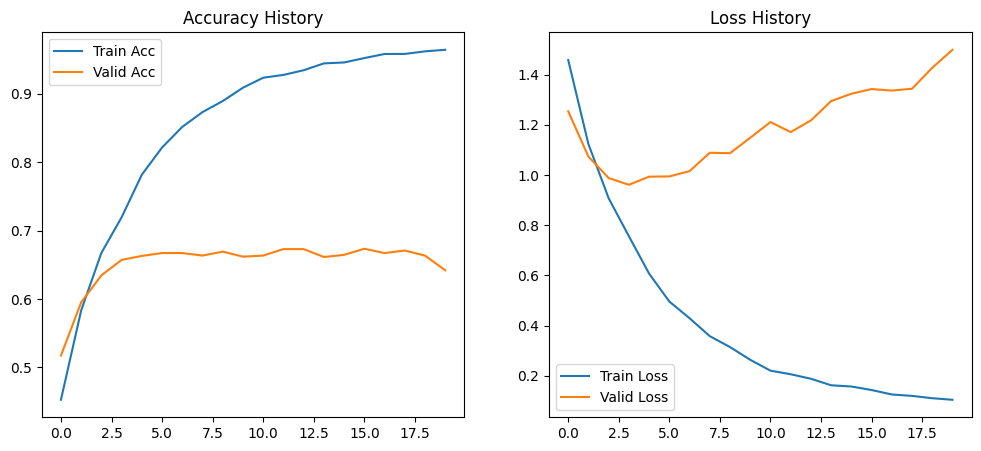

In [6]:
print("\n❄️ GIAI ĐOẠN 1: ĐÓNG BĂNG (WARM-UP) - 5 Epochs")

# Đóng băng toàn bộ backbone
for param in model.parameters():
    param.requires_grad = False
# Mở khóa lớp classifier cuối cùng
for param in model.classifier.parameters():
    param.requires_grad = True

# Optimizer cơ bản
optimizer_ft = optim.Adam(model.classifier.parameters(), lr=1e-3)

model, _ = train_model(model, criterion, optimizer_ft, num_epochs=5)


print("\n🔥 GIAI ĐOẠN 2: FINE-TUNING (RÃ ĐÔNG) - 20 Epochs")

# Rã đông toàn bộ
for param in model.parameters():
    param.requires_grad = True

optimizer_ft = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

model, history = train_model(model, criterion, optimizer_ft, num_epochs=20)

torch.save(model.state_dict(), 'efficientnet_b0_final_best.pth')
print("🎉 Đã lưu model tại: efficientnet_b0_final_best.pth")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Valid Acc')
plt.title('Accuracy History')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Valid Loss')
plt.title('Loss History')
plt.legend()
plt.show()